In [1]:
import os 
import sys
import time
import pickle
import logging
import pandas as pd
from glob import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.pipeline import Pipeline

import utils
import data_prep as prep
import train_select as ts

logging.basicConfig(
    format='%(levelname)s %(message)s',
    stream=sys.stdout, level=logging.INFO)

In [16]:
random_state = 42
batch_dir = "dataset/batches"
test_ratio = .2
n_train = 160

partial_fit_classifiers = {
    'SGD-SVM': SGDClassifier(random_state=random_state, loss='hinge'),
    'SGD-Log': SGDClassifier(random_state=random_state, loss='log'),
    'Perceptron': Perceptron(random_state=random_state),
    'NB Multinomial': MultinomialNB(alpha=0.01),
    'Passive-Aggressive': PassiveAggressiveClassifier(random_state=random_state)
}

In [17]:
test_batch_names, train_batch_names = ts.split_test(batch_dir=batch_dir, test_ratio=test_ratio)

INFO Number of test batches: 49
INFO Number of train batches: 197


A total of 49 batchs will be held out as test set. We will hold out extra 37 batches as a validation set to be used for hyperparameter fine tuning. Also, during training of 150 batches, validation error is measured every tenth batches, then used to train and update the model. 

In [18]:
results = ts.train_predict(partial_fit_classifiers, train_batch_names, n_train = n_train)

INFO batch 10 / 160
INFO Number of validation sample: 2335
INFO ===== F-beta score (beta=0.5) ==========
INFO SGD-SVM: 0.9059699755615035
INFO SGD-Log: 0.9116087212728343
INFO Perceptron: 0.8921091361938187
INFO NB Multinomial: 0.8932309839497556
INFO PA: 0.8841843088418432
INFO ========================================
INFO batch 20 / 160
INFO Number of validation sample: 2469
INFO ===== F-beta score (beta=0.5) ==========
INFO SGD-SVM: 0.9349919743178171
INFO SGD-Log: 0.9284128745837957
INFO Perceptron: 0.9299577009206268
INFO NB Multinomial: 0.8950946414289522
INFO PA: 0.9206713354262256
INFO ========================================
INFO batch 30 / 160
INFO Number of validation sample: 2464
INFO ===== F-beta score (beta=0.5) ==========
INFO SGD-SVM: 0.9233289646133683
INFO SGD-Log: 0.91672984584281
INFO Perceptron: 0.883307573415765
INFO NB Multinomial: 0.8869602032176124
INFO PA: 0.8887306109528332
INFO ========================================
INFO batch 40 / 160
INFO Number of valid

# Plot results

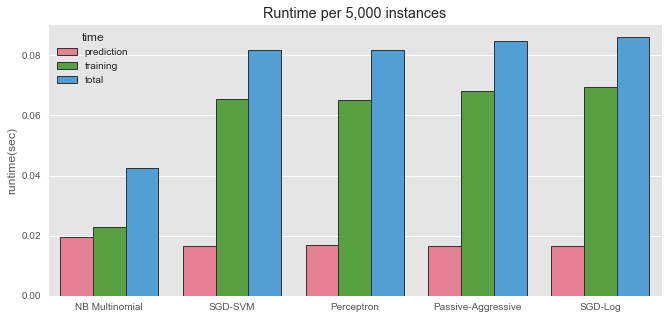

In [19]:
time_res = ts.get_time_res(results)
ts.plot_time(time_res)

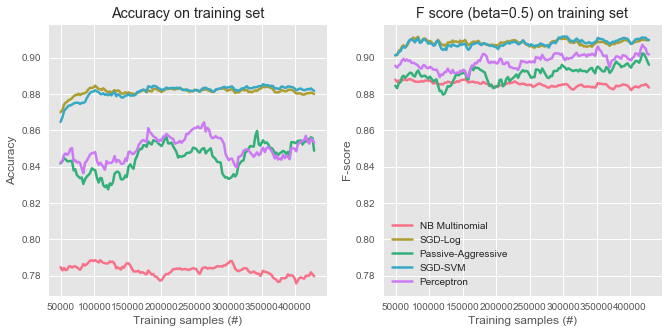

In [20]:
ts.plot_score(results)

In [21]:
ts.get_test_score(results)

,mean_test_acc,mean_test_f
clf,,
NB Multinomial,0.792685,0.889875
Perceptron,0.850928,0.896680
Passive-Aggressive,0.851597,0.896493
SGD-Log,0.881116,0.907052
SGD-SVM,0.882455,0.907165


# Hyperparameter tuning via grid search

In [52]:

def concat_val_batches(train_batch_names, n_train, show_eta=False):
    val_batch_names = train_batch_names[ n_train: ]
    features = None
    labels = None
    logging.info("Concatenating {} validation batches".format(len(val_batch_names)))
    if show_eta:
        pbar = pyprind.ProgBar(len(val_batch_names))
    for file in val_batch_names:
        X, y = ts.load_batches(file)
        if features is None:
            features = X
            labels = y
        else:
            features = pd.concat([ features, X ])
            labels = np.concatenate([ labels, y ])
        
            if show_eta:
                pbar.update()
    # logging.info("Validation set shape: {}".format(features.shape))
    return features, labels



In [54]:
val_X, val_y =  concat_val_batches(train_batch_names, n_train, True)

INFO Concatenating 37 validation batches


0% [############################# ] 100% | ETA: 00:00:00

In [34]:
loss = ['hinge', 'log']
alpha = [.000001, .00001, .0001, .001]
l1_ratio = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9]

In [41]:
import itertools
c = list(itertools.product(alpha, l1_ratio))
c[1]

(1e-06, 0.1)

In [48]:
params = list(itertools.product(alpha, l1_ratio))
params_ = list(itertools.product(loss, params))
param_dict = [{'loss': c[0], 'alpha': c[1][0], 'l1_ratio': c[1][1], 'val_f_score': 0.} for c in params_]

In [51]:
param_dict[0]

{'alpha': 1e-06, 'l1_ratio': 0.0, 'loss': 'hinge', 'val_f_score': 0.0}

In [65]:
def sgd_grid_search(train_batch_names, n_train, loss, alpha, l1_ratio):
    
    classes = np.array([ 0, 1 ])
    files_to_read = train_batch_names[ :n_train ]
    X_val, y_val = concat_val_batches(train_batch_names, n_train, True)
    
    params = list(itertools.product(alpha, l1_ratio))
    params_ = list(itertools.product(loss, params))
    param_dict = [{'loss': c[0], 'alpha': c[1][0], 'l1_ratio': c[1][1], 'val_f_score': 0.} for c in params_]
    
    for i, p in enumerate(param_dict):
        clf = SGDClassifier(loss=p['loss'], alpha=p['alpha'], l1_ratio=p['l1_ratio'], 
                            random_state=random_state)
        
        logging.info("{}/{} Evaluating hyperparameters: {}".format(i+1, len(param_dict), p))
        for i, filename in enumerate(files_to_read):
            X_train, y_train = ts.load_batches(filename) 
            clf.partial_fit(X_train, y_train, classes=classes)
            pred_val = clf.predict(X_val)
            p['val_f_score'] = fbeta_score(y_val, pred_val, beta=.5)
    
    return pd.DataFrame(param_dict)

In [62]:
param_dict = sgd_grid_search(train_batch_names, n_train, loss, alpha, l1_ratio)

INFO Concatenating 37 validation batches


0% [############################# ] 100% | ETA: 00:00:00

INFO 1/80 Evaluating hyperparameters: {'loss': 'hinge', 'alpha': 1e-06, 'l1_ratio': 0.0, 'val_f_score': 0.0}
INFO 2/80 Evaluating hyperparameters: {'loss': 'hinge', 'alpha': 1e-06, 'l1_ratio': 0.1, 'val_f_score': 0.0}
INFO 3/80 Evaluating hyperparameters: {'loss': 'hinge', 'alpha': 1e-06, 'l1_ratio': 0.2, 'val_f_score': 0.0}
INFO 4/80 Evaluating hyperparameters: {'loss': 'hinge', 'alpha': 1e-06, 'l1_ratio': 0.30000000000000004, 'val_f_score': 0.0}
INFO 5/80 Evaluating hyperparameters: {'loss': 'hinge', 'alpha': 1e-06, 'l1_ratio': 0.4, 'val_f_score': 0.0}
INFO 6/80 Evaluating hyperparameters: {'loss': 'hinge', 'alpha': 1e-06, 'l1_ratio': 0.5, 'val_f_score': 0.0}
INFO 7/80 Evaluating hyperparameters: {'loss': 'hinge', 'alpha': 1e-06, 'l1_ratio': 0.6000000000000001, 'val_f_score': 0.0}
INFO 8/80 Evaluating hyperparameters: {'loss': 'hinge', 'alpha': 1e-06, 'l1_ratio': 0.7000000000000001, 'val_f_score': 0.0}
INFO 9/80 Evaluating hyperparameters: {'loss': 'hinge', 'alpha': 1e-06, 'l1_ratio'

INFO 74/80 Evaluating hyperparameters: {'loss': 'log', 'alpha': 0.001, 'l1_ratio': 0.30000000000000004, 'val_f_score': 0.0}
INFO 75/80 Evaluating hyperparameters: {'loss': 'log', 'alpha': 0.001, 'l1_ratio': 0.4, 'val_f_score': 0.0}
INFO 76/80 Evaluating hyperparameters: {'loss': 'log', 'alpha': 0.001, 'l1_ratio': 0.5, 'val_f_score': 0.0}
INFO 77/80 Evaluating hyperparameters: {'loss': 'log', 'alpha': 0.001, 'l1_ratio': 0.6000000000000001, 'val_f_score': 0.0}
INFO 78/80 Evaluating hyperparameters: {'loss': 'log', 'alpha': 0.001, 'l1_ratio': 0.7000000000000001, 'val_f_score': 0.0}
INFO 79/80 Evaluating hyperparameters: {'loss': 'log', 'alpha': 0.001, 'l1_ratio': 0.8, 'val_f_score': 0.0}
INFO 80/80 Evaluating hyperparameters: {'loss': 'log', 'alpha': 0.001, 'l1_ratio': 0.9, 'val_f_score': 0.0}


[{'alpha': 1e-06,
  'l1_ratio': 0.0,
  'loss': 'hinge',
  'val_f_score': 0.88421578174256055},
 {'alpha': 1e-06,
  'l1_ratio': 0.1,
  'loss': 'hinge',
  'val_f_score': 0.88421578174256055},
 {'alpha': 1e-06,
  'l1_ratio': 0.2,
  'loss': 'hinge',
  'val_f_score': 0.88421578174256055},
 {'alpha': 1e-06,
  'l1_ratio': 0.30000000000000004,
  'loss': 'hinge',
  'val_f_score': 0.88421578174256055},
 {'alpha': 1e-06,
  'l1_ratio': 0.4,
  'loss': 'hinge',
  'val_f_score': 0.88421578174256055},
 {'alpha': 1e-06,
  'l1_ratio': 0.5,
  'loss': 'hinge',
  'val_f_score': 0.88421578174256055},
 {'alpha': 1e-06,
  'l1_ratio': 0.6000000000000001,
  'loss': 'hinge',
  'val_f_score': 0.88421578174256055},
 {'alpha': 1e-06,
  'l1_ratio': 0.7000000000000001,
  'loss': 'hinge',
  'val_f_score': 0.88421578174256055},
 {'alpha': 1e-06,
  'l1_ratio': 0.8,
  'loss': 'hinge',
  'val_f_score': 0.88421578174256055},
 {'alpha': 1e-06,
  'l1_ratio': 0.9,
  'loss': 'hinge',
  'val_f_score': 0.88421578174256055},
 {'a

In [63]:
param_dict = [{'alpha': 1e-06,
  'l1_ratio': 0.0,
  'loss': 'hinge',
  'val_f_score': 0.88421578174256055},
 {'alpha': 1e-06,
  'l1_ratio': 0.1,
  'loss': 'hinge',
  'val_f_score': 0.88421578174256055},
 {'alpha': 1e-06,
  'l1_ratio': 0.2,
  'loss': 'hinge',
  'val_f_score': 0.88421578174256055},
 {'alpha': 1e-06,
  'l1_ratio': 0.30000000000000004,
  'loss': 'hinge',
  'val_f_score': 0.88421578174256055},
 {'alpha': 1e-06,
  'l1_ratio': 0.4,
  'loss': 'hinge',
  'val_f_score': 0.88421578174256055},
 {'alpha': 1e-06,
  'l1_ratio': 0.5,
  'loss': 'hinge',
  'val_f_score': 0.88421578174256055},
 {'alpha': 1e-06,
  'l1_ratio': 0.6000000000000001,
  'loss': 'hinge',
  'val_f_score': 0.88421578174256055},
 {'alpha': 1e-06,
  'l1_ratio': 0.7000000000000001,
  'loss': 'hinge',
  'val_f_score': 0.88421578174256055},
 {'alpha': 1e-06,
  'l1_ratio': 0.8,
  'loss': 'hinge',
  'val_f_score': 0.88421578174256055},
 {'alpha': 1e-06,
  'l1_ratio': 0.9,
  'loss': 'hinge',
  'val_f_score': 0.88421578174256055},
 {'alpha': 1e-05,
  'l1_ratio': 0.0,
  'loss': 'hinge',
  'val_f_score': 0.91194017817551498},
 {'alpha': 1e-05,
  'l1_ratio': 0.1,
  'loss': 'hinge',
  'val_f_score': 0.91194017817551498},
 {'alpha': 1e-05,
  'l1_ratio': 0.2,
  'loss': 'hinge',
  'val_f_score': 0.91194017817551498},
 {'alpha': 1e-05,
  'l1_ratio': 0.30000000000000004,
  'loss': 'hinge',
  'val_f_score': 0.91194017817551498},
 {'alpha': 1e-05,
  'l1_ratio': 0.4,
  'loss': 'hinge',
  'val_f_score': 0.91194017817551498},
 {'alpha': 1e-05,
  'l1_ratio': 0.5,
  'loss': 'hinge',
  'val_f_score': 0.91194017817551498},
 {'alpha': 1e-05,
  'l1_ratio': 0.6000000000000001,
  'loss': 'hinge',
  'val_f_score': 0.91194017817551498},
 {'alpha': 1e-05,
  'l1_ratio': 0.7000000000000001,
  'loss': 'hinge',
  'val_f_score': 0.91194017817551498},
 {'alpha': 1e-05,
  'l1_ratio': 0.8,
  'loss': 'hinge',
  'val_f_score': 0.91194017817551498},
 {'alpha': 1e-05,
  'l1_ratio': 0.9,
  'loss': 'hinge',
  'val_f_score': 0.91194017817551498},
 {'alpha': 0.0001,
  'l1_ratio': 0.0,
  'loss': 'hinge',
  'val_f_score': 0.91220645697298564},
 {'alpha': 0.0001,
  'l1_ratio': 0.1,
  'loss': 'hinge',
  'val_f_score': 0.91220645697298564},
 {'alpha': 0.0001,
  'l1_ratio': 0.2,
  'loss': 'hinge',
  'val_f_score': 0.91220645697298564},
 {'alpha': 0.0001,
  'l1_ratio': 0.30000000000000004,
  'loss': 'hinge',
  'val_f_score': 0.91220645697298564},
 {'alpha': 0.0001,
  'l1_ratio': 0.4,
  'loss': 'hinge',
  'val_f_score': 0.91220645697298564},
 {'alpha': 0.0001,
  'l1_ratio': 0.5,
  'loss': 'hinge',
  'val_f_score': 0.91220645697298564},
 {'alpha': 0.0001,
  'l1_ratio': 0.6000000000000001,
  'loss': 'hinge',
  'val_f_score': 0.91220645697298564},
 {'alpha': 0.0001,
  'l1_ratio': 0.7000000000000001,
  'loss': 'hinge',
  'val_f_score': 0.91220645697298564},
 {'alpha': 0.0001,
  'l1_ratio': 0.8,
  'loss': 'hinge',
  'val_f_score': 0.91220645697298564},
 {'alpha': 0.0001,
  'l1_ratio': 0.9,
  'loss': 'hinge',
  'val_f_score': 0.91220645697298564},
 {'alpha': 0.001,
  'l1_ratio': 0.0,
  'loss': 'hinge',
  'val_f_score': 0.88770565017441805},
 {'alpha': 0.001,
  'l1_ratio': 0.1,
  'loss': 'hinge',
  'val_f_score': 0.88770565017441805},
 {'alpha': 0.001,
  'l1_ratio': 0.2,
  'loss': 'hinge',
  'val_f_score': 0.88770565017441805},
 {'alpha': 0.001,
  'l1_ratio': 0.30000000000000004,
  'loss': 'hinge',
  'val_f_score': 0.88770565017441805},
 {'alpha': 0.001,
  'l1_ratio': 0.4,
  'loss': 'hinge',
  'val_f_score': 0.88770565017441805},
 {'alpha': 0.001,
  'l1_ratio': 0.5,
  'loss': 'hinge',
  'val_f_score': 0.88770565017441805},
 {'alpha': 0.001,
  'l1_ratio': 0.6000000000000001,
  'loss': 'hinge',
  'val_f_score': 0.88770565017441805},
 {'alpha': 0.001,
  'l1_ratio': 0.7000000000000001,
  'loss': 'hinge',
  'val_f_score': 0.88770565017441805},
 {'alpha': 0.001,
  'l1_ratio': 0.8,
  'loss': 'hinge',
  'val_f_score': 0.88770565017441805},
 {'alpha': 0.001,
  'l1_ratio': 0.9,
  'loss': 'hinge',
  'val_f_score': 0.88770565017441805},
 {'alpha': 1e-06,
  'l1_ratio': 0.0,
  'loss': 'log',
  'val_f_score': 0.89895304568527934},
 {'alpha': 1e-06,
  'l1_ratio': 0.1,
  'loss': 'log',
  'val_f_score': 0.89895304568527934},
 {'alpha': 1e-06,
  'l1_ratio': 0.2,
  'loss': 'log',
  'val_f_score': 0.89895304568527934},
 {'alpha': 1e-06,
  'l1_ratio': 0.30000000000000004,
  'loss': 'log',
  'val_f_score': 0.89895304568527934},
 {'alpha': 1e-06,
  'l1_ratio': 0.4,
  'loss': 'log',
  'val_f_score': 0.89895304568527934},
 {'alpha': 1e-06,
  'l1_ratio': 0.5,
  'loss': 'log',
  'val_f_score': 0.89895304568527934},
 {'alpha': 1e-06,
  'l1_ratio': 0.6000000000000001,
  'loss': 'log',
  'val_f_score': 0.89895304568527934},
 {'alpha': 1e-06,
  'l1_ratio': 0.7000000000000001,
  'loss': 'log',
  'val_f_score': 0.89895304568527934},
 {'alpha': 1e-06,
  'l1_ratio': 0.8,
  'loss': 'log',
  'val_f_score': 0.89895304568527934},
 {'alpha': 1e-06,
  'l1_ratio': 0.9,
  'loss': 'log',
  'val_f_score': 0.89895304568527934},
 {'alpha': 1e-05,
  'l1_ratio': 0.0,
  'loss': 'log',
  'val_f_score': 0.91623197509285548},
 {'alpha': 1e-05,
  'l1_ratio': 0.1,
  'loss': 'log',
  'val_f_score': 0.91623197509285548},
 {'alpha': 1e-05,
  'l1_ratio': 0.2,
  'loss': 'log',
  'val_f_score': 0.91623197509285548},
 {'alpha': 1e-05,
  'l1_ratio': 0.30000000000000004,
  'loss': 'log',
  'val_f_score': 0.91623197509285548},
 {'alpha': 1e-05,
  'l1_ratio': 0.4,
  'loss': 'log',
  'val_f_score': 0.91623197509285548},
 {'alpha': 1e-05,
  'l1_ratio': 0.5,
  'loss': 'log',
  'val_f_score': 0.91623197509285548},
 {'alpha': 1e-05,
  'l1_ratio': 0.6000000000000001,
  'loss': 'log',
  'val_f_score': 0.91623197509285548},
 {'alpha': 1e-05,
  'l1_ratio': 0.7000000000000001,
  'loss': 'log',
  'val_f_score': 0.91623197509285548},
 {'alpha': 1e-05,
  'l1_ratio': 0.8,
  'loss': 'log',
  'val_f_score': 0.91623197509285548},
 {'alpha': 1e-05,
  'l1_ratio': 0.9,
  'loss': 'log',
  'val_f_score': 0.91623197509285548},
 {'alpha': 0.0001,
  'l1_ratio': 0.0,
  'loss': 'log',
  'val_f_score': 0.90757608365404085},
 {'alpha': 0.0001,
  'l1_ratio': 0.1,
  'loss': 'log',
  'val_f_score': 0.90757608365404085},
 {'alpha': 0.0001,
  'l1_ratio': 0.2,
  'loss': 'log',
  'val_f_score': 0.90757608365404085},
 {'alpha': 0.0001,
  'l1_ratio': 0.30000000000000004,
  'loss': 'log',
  'val_f_score': 0.90757608365404085},
 {'alpha': 0.0001,
  'l1_ratio': 0.4,
  'loss': 'log',
  'val_f_score': 0.90757608365404085},
 {'alpha': 0.0001,
  'l1_ratio': 0.5,
  'loss': 'log',
  'val_f_score': 0.90757608365404085},
 {'alpha': 0.0001,
  'l1_ratio': 0.6000000000000001,
  'loss': 'log',
  'val_f_score': 0.90757608365404085},
 {'alpha': 0.0001,
  'l1_ratio': 0.7000000000000001,
  'loss': 'log',
  'val_f_score': 0.90757608365404085},
 {'alpha': 0.0001,
  'l1_ratio': 0.8,
  'loss': 'log',
  'val_f_score': 0.90757608365404085},
 {'alpha': 0.0001,
  'l1_ratio': 0.9,
  'loss': 'log',
  'val_f_score': 0.90757608365404085},
 {'alpha': 0.001,
  'l1_ratio': 0.0,
  'loss': 'log',
  'val_f_score': 0.89471218042165346},
 {'alpha': 0.001,
  'l1_ratio': 0.1,
  'loss': 'log',
  'val_f_score': 0.89471218042165346},
 {'alpha': 0.001,
  'l1_ratio': 0.2,
  'loss': 'log',
  'val_f_score': 0.89471218042165346},
 {'alpha': 0.001,
  'l1_ratio': 0.30000000000000004,
  'loss': 'log',
  'val_f_score': 0.89471218042165346},
 {'alpha': 0.001,
  'l1_ratio': 0.4,
  'loss': 'log',
  'val_f_score': 0.89471218042165346},
 {'alpha': 0.001,
  'l1_ratio': 0.5,
  'loss': 'log',
  'val_f_score': 0.89471218042165346},
 {'alpha': 0.001,
  'l1_ratio': 0.6000000000000001,
  'loss': 'log',
  'val_f_score': 0.89471218042165346},
 {'alpha': 0.001,
  'l1_ratio': 0.7000000000000001,
  'loss': 'log',
  'val_f_score': 0.89471218042165346},
 {'alpha': 0.001,
  'l1_ratio': 0.8,
  'loss': 'log',
  'val_f_score': 0.89471218042165346},
 {'alpha': 0.001,
  'l1_ratio': 0.9,
  'loss': 'log',
  'val_f_score': 0.89471218042165346}]

In [64]:
pd.DataFrame(param_dict)

,alpha,l1_ratio,loss,val_f_score
0,0.000001,0.0,hinge,0.884216
1,0.000001,0.1,hinge,0.884216
2,0.000001,0.2,hinge,0.884216
3,0.000001,0.3,hinge,0.884216
4,0.000001,0.4,hinge,0.884216
5,0.000001,0.5,hinge,0.884216
6,0.000001,0.6,hinge,0.884216
7,0.000001,0.7,hinge,0.884216
8,0.000001,0.8,hinge,0.884216
9,0.000001,0.9,hinge,0.884216
